In [5]:
import cv2
import mediapipe as mp
import pandas as pd
import math

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
mp_hands = mp.solutions.hands

# cnt=0
total_landmarks=[]
total_landmarks_hands=[]
dir_r = None
dir_l = None

# For webcam input:
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

path = 'shorts26.mp4'
# example video: shorts12: , short16:측정불가, shorts17: 2명이상, shorts20,,,

if path:
    cap = cv2.VideoCapture(path)
else:
    cap = cv2.VideoCapture(0)

with mp_face_mesh.FaceMesh( max_num_faces=1, refine_landmarks=True,
    min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    with mp_hands.Hands(model_complexity=0,min_detection_confidence=0.5,
                        min_tracking_confidence=0.5) as hands:
        
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Ignoring empty camera frame.")
                # If loading a video, use 'break' instead of 'continue'.
                continue

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(image)
            results_hands = hands.process(image)

            # Draw the face mesh annotations on the image.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            if results.multi_face_landmarks:
                for face_landmarks in (results.multi_face_landmarks):
                    # eyes
                    FACEMESH_LEFT_EYE = frozenset([(263, 249), (249, 390), (390, 373), (373, 374),
                               (374, 380), (380, 381), (381, 382), (382, 362),
                               (263, 466), (466, 388), (388, 387), (387, 386),
                               (386, 385), (385, 384), (384, 398), (398, 362)])
                    FACEMESH_LEFT_EYEBROW = frozenset([(276, 283), (283, 282), (282, 295),
                                                       (295, 285), (300, 293), (293, 334),
                                                       (334, 296), (296, 336)])
                    FACEMESH_RIGHT_EYE = frozenset([(33, 7), (7, 163), (163, 144), (144, 145),
                                                    (145, 153), (153, 154), (154, 155), (155, 133),
                                                    (33, 246), (246, 161), (161, 160), (160, 159),
                                                    (159, 158), (158, 157), (157, 173), (173, 133)])
                    FACEMESH_RIGHT_EYEBROW = frozenset([(46, 53), (53, 52), (52, 65), (65, 55),
                                                        (70, 63), (63, 105), (105, 66), (66, 107)])
                    FACEMESH_CONTOURS = frozenset().union(*[
                        FACEMESH_LEFT_EYE, FACEMESH_LEFT_EYEBROW,
                        FACEMESH_RIGHT_EYE,FACEMESH_RIGHT_EYEBROW])
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=FACEMESH_CONTOURS,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
                    )
                    # irises
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_IRISES,
                        # mp_face_mesh
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style()
                    )
                    total_landmarks.append(face_landmarks.landmark)
                    
                    # Make DataFrames------------------------------------------------------------
                    # iris data frame
                    FACEMESH_RIGHT_IRIS = frozenset([(469, 470), (470, 471), (471, 472),(472, 469)])
                    FACEMESH_LEFT_IRIS = frozenset([(474, 475), (475, 476), (476, 477),(477, 474)])
                    FACEMESH_IRISES = frozenset().union(*[FACEMESH_LEFT_IRIS, FACEMESH_RIGHT_IRIS])
                    irises=[]
                    
                    for iris, _ in FACEMESH_IRISES:
                        irises.append(iris)
                    irises.sort() # order
                    right = irises[:len(FACEMESH_RIGHT_IRIS)]
                    left = irises[len(FACEMESH_RIGHT_IRIS):]
                    total = []
                    
                    for n,_ in enumerate(irises):
                        n+=1
                        # 좌표값이 오른쪽눈 < 왼쪽눈 / 각 4개씩
                        if n <=len(FACEMESH_LEFT_IRIS):
                            direction = 'right'
                        else:
                            n-=len(FACEMESH_LEFT_IRIS)
                            direction = 'left'
                            
                        now = [_,direction ,face_landmarks.landmark[_].x,face_landmarks.landmark[_].y,face_landmarks.landmark[_].z]
                        total.append(now)
                        
                    iris_df = pd.DataFrame(total, columns = ['idx','dir','x','y','z'])
                    
                    x = image.shape[1]
                    y = image.shape[0]
                    iris_df['x'] = iris_df['x']*x
                    iris_df['y'] = iris_df['y']*y
                    iris_df['x'] = iris_df['x'].astype('int64')
                    iris_df['y'] = iris_df['y'].astype('int64')
                    
                    # eyes data frame
                    FACEMESH_LEFT_EYE = frozenset([(263, 249), (249, 390), (390, 373), (373, 374),
                                       (374, 380), (380, 381), (381, 382), (382, 362),
                                       (263, 466), (466, 388), (388, 387), (387, 386),
                                       (386, 385), (385, 384), (384, 398), (398, 362)])
                    FACEMESH_RIGHT_EYE = frozenset([(33, 7), (7, 163), (163, 144), (144, 145),
                                                    (145, 153), (153, 154), (154, 155), (155, 133),
                                                    (33, 246), (246, 161), (161, 160), (160, 159),
                                                    (159, 158), (158, 157), (157, 173), (173, 133)])
                    FACEMESH_EYES = frozenset().union(*[FACEMESH_LEFT_EYE, FACEMESH_RIGHT_EYE])
                    eyes=[]
                    
                    for eye, _ in FACEMESH_EYES:
                        eyes.append(eye)
                        eyes.append(_)
                    eyes = set(eyes)
                    eyes = list(eyes)
                    eyes.sort() # order
                    right = irises[:len(FACEMESH_LEFT_EYE)]
                    left = irises[len(FACEMESH_LEFT_EYE):]
                    total = []

                    for n,_ in enumerate(eyes):
                        n+=1
                        # 좌표값이 오른쪽눈 < 왼쪽눈 / 각 16개씩
                        if n <= len(FACEMESH_LEFT_EYE): 
                            direction = 'right'     
                        else:
                            n-=int(len(FACEMESH_LEFT_EYE))
                            direction = 'left'
                        now = [_,direction ,face_landmarks.landmark[_].x,face_landmarks.landmark[_].y,face_landmarks.landmark[_].z]
                        total.append(now)
                    eyes_df = pd.DataFrame(total, columns = ['idx','dir','x','y','z'])
                    eyes_df['x'] = eyes_df['x']*x
                    eyes_df['y'] = eyes_df['y']*y
                    eyes_df['x'] = eyes_df['x'].astype('int64')
                    eyes_df['y'] = eyes_df['y'].astype('int64')
                    
                    # Gaze Point Estimation------------------------------------------------------------
                    # 오른쪽 동공의 각 끝 좌표
                    n469_x, n469_y = iris_df[iris_df['idx']==469].x,iris_df[iris_df['idx']==469].y
                    n471_x, n471_y = iris_df[iris_df['idx']==471].x,iris_df[iris_df['idx']==471].y
                    dot_r = (int(n469_x) + int(n471_x)) / 2, (int(n469_y) + int(n471_y)) / 2
                    # 왼쪽 동공의 각 끝 좌표
                    n474_x, n474_y = iris_df[iris_df['idx']==474].x,iris_df[iris_df['idx']==474].y
                    n476_x, n476_y = iris_df[iris_df['idx']==476].x,iris_df[iris_df['idx']==476].y
                    dot_l = (int(n474_x) + int(n476_x)) / 2, (int(n474_y) + int(n476_y)) / 2
                    
                    # 오른쪽 눈꺼풀의 각 끝 좌표
                    n33 = (eyes_df[eyes_df['idx']==33].x,eyes_df[eyes_df['idx']==33].y)
                    n133 = (eyes_df[eyes_df['idx']==133].x,eyes_df[eyes_df['idx']==133].y) 
                    dist_r = math.dist(n33,n133)
                    # 왼쪽 눈꺼풀의 각 끝 좌표
                    n263 = (eyes_df[eyes_df['idx']==263].x,eyes_df[eyes_df['idx']==263].y)
                    n362 = (eyes_df[eyes_df['idx']==362].x,eyes_df[eyes_df['idx']==362].y)
                    dist_l = math.dist(n263,n362)
                    
                    # 오른쪽 밑 눈꺼풀
                    n145 = (eyes_df[eyes_df['idx']==145].x,eyes_df[eyes_df['idx']==145].y)
                    # 왼쪽 밑 눈꺼풀
                    n374 = (eyes_df[eyes_df['idx']==374].x,eyes_df[eyes_df['idx']==374].y)
                    
                    thres = 0.47 # thres < 0.5, thres~ centre ~(1-thres)
                    thres_ = 1-thres
                
                    r_ratio = round((math.dist(dot_r, n133)/dist_r),5) # if ratio < thres: left
                    l_ratio = round((math.dist(dot_l, n263)/dist_l),5) # if ratio < thres: left
                    up_r = iris_df[iris_df['idx']==472]['y'][3] - eyes_df[eyes_df['idx']==145].y[4] # if up<0: up
                    up_l = iris_df[iris_df['idx']==477]['y'][7] - eyes_df[eyes_df['idx']==374].y[20] # if up<0: up
                        
                        
                    if r_ratio or l_ratio:
                        if (up_r >= 0) or (up_l >= 0) :
                            if r_ratio:
                                if r_ratio < thres:
                                    dir_r = 'Right'
                                elif (r_ratio >= thres) and (r_ratio <=thres_):
                                    dir_r = 'Center'
                                elif r_ratio > thres:
                                    dir_r = 'Left'
                            if l_ratio:
                                if l_ratio < thres:
                                    dir_l= 'Right'
                                elif (l_ratio >= thres) and (l_ratio <=thres_):
                                    dir_l = 'Center'
                                elif l_ratio > thres:
                                    dir_l = 'Left'
                            if dir_r == dir_l:
                                dir_ = dir_r
                            elif ((dir_r =='Right') and (dir_l =='Left')) or ((dir_r == 'Left') and (dir_l == 'Right')):
                                dir_ = 'Center'
                            else: # [rightcenter, leftcenter, centerright, centerleft]
                                dir_ = dir_r + dir_l
                                if (dir_ =='RightCenter') or (dir_ =='CenterRight'):
                                    dir_ = 'RightCenter'
                                if (dir_ =='LeftCenter') or (dir_ =='CenterLeft'):
                                    dir_ = 'LeftCenter'
                        else: # both 'up_r' and 'up_l' are < 0 in this case
                            dir_ = 'Up' # as Background
            # hands pose--------------------------------------------------        
            if results_hands.multi_hand_landmarks:
                for hand_landmarks in (results_hands.multi_hand_landmarks):
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=hand_landmarks,
                        connections=mp_hands.HAND_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style(),
                        connection_drawing_spec=mp_drawing_styles.get_default_hand_connections_style()
                    )
                    total_landmarks_hands.append(hand_landmarks.landmark)
            
            # text direction--------------------------------------------------   
            if dir_:
                org=(700,700)
                font=cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(image,dir_,org,font,1,(255,0,0),2)
                size, BaseLine=cv2.getTextSize(dir_,font,1,2)

    #                 # rectangle
    #                 min_y = int(image.shape[0] * 1/3)
    #                 min_x = int(image.shape[1] * 1/3)
    #                 max_y = int(image.shape[0] * 2/3)
    #                 max_x = int(image.shape[1] * 2/3)        
    # #                 cv2.rectangle(image, (100,100), (300,300), (0, 255, 0), 3)
    #                 cv2.rectangle(image, (min_x,min_y), (max_x,max_y), (0, 255, 0), 3)

            # Flip the image horizontally for a selfie-view display.
#             cv2.imshow('MediaPipe', cv2.flip(image, 1))
            cv2.imshow('MediaPipe', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
cap.release()
cv2.destroyAllWindows()

In [6]:
# 1개의 영상에서 frame 개수
frame_n = len(total_landmarks)
# 1개의 frame에서 나올 수 있는 landmark개수
landmarks_n = len(total_landmarks[0])
print('frame개수: {}, frame별 landmarks개수: {}'.format(frame_n, landmarks_n))

frame개수: 462, frame별 landmarks개수: 478


### IRIS

In [9]:
FACEMESH_RIGHT_IRIS = frozenset([(469, 470), (470, 471), (471, 472),(472, 469)])
# 469, 470, 471, 472
FACEMESH_LEFT_IRIS = frozenset([(474, 475), (475, 476), (476, 477),(477, 474)])
# 474, 475, 476, 477
FACEMESH_IRISES = frozenset().union(*[FACEMESH_LEFT_IRIS, FACEMESH_RIGHT_IRIS])

In [10]:
irises=[]
for iris, _ in FACEMESH_IRISES:
    irises.append(iris)
irises.sort() # 오름차순
irises

[469, 470, 471, 472, 474, 475, 476, 477]

In [11]:
right = irises[:len(FACEMESH_RIGHT_IRIS)]
left = irises[len(FACEMESH_RIGHT_IRIS):]
total = []
for n,_ in enumerate(irises):
    n+=1
# 오른쪽눈 < 왼쪽눈 / 각 4개씩
    if n <=len(FACEMESH_LEFT_IRIS):
        direction = 'right'
        print(n,'right',_)

    else:
        n-=len(FACEMESH_LEFT_IRIS)
        direction = 'left'
        print(n,'left',_)
    
    # 변수명: e.g. right_e2_y = 0.xxxxx
#         globals()['{}_e{}_x'.format(direction,n)] = total_landmarks[0][_].x
#         globals()['{}_e{}_y'.format(direction,n)] = total_landmarks[0][_].y
#         globals()['{}_e{}_z'.format(direction,n)] = total_landmarks[0][_].z

    now = [_,direction ,total_landmarks[0][_].x,total_landmarks[0][_].y,total_landmarks[0][_].z]
    total.append(now)
    if direction =='right':
        right.append(now)
    else:
        left.append(now)
    
iris_df = pd.DataFrame(total, columns = ['idx','dir','x','y','z'])

1 right 469
2 right 470
3 right 471
4 right 472
1 left 474
2 left 475
3 left 476
4 left 477


In [16]:
x = image.shape[1]
y = image.shape[0]
iris_df['x'] = iris_df['x']*x
iris_df['y'] = iris_df['y']*y
iris_df['x'] = iris_df['x'].astype('int64')
iris_df['y'] = iris_df['y'].astype('int64')
iris_df

,idx,dir,x,y,z
0,469,right,2367680,913952,0.004941
1,470,right,2318400,890968,0.004941
2,471,right,2278080,913952,0.004941
3,472,right,2327360,936936,0.004941
4,474,left,2896320,926120,0.018324
5,475,left,2856000,899080,0.018324
6,476,left,2813440,920712,0.018324
7,477,left,2856000,947752,0.018324


### EYES

In [17]:
FACEMESH_LEFT_EYE = frozenset([(263, 249), (249, 390), (390, 373), (373, 374),
                               (374, 380), (380, 381), (381, 382), (382, 362),
                               (263, 466), (466, 388), (388, 387), (387, 386),
                               (386, 385), (385, 384), (384, 398), (398, 362)])

FACEMESH_RIGHT_EYE = frozenset([(33, 7), (7, 163), (163, 144), (144, 145),
                                (145, 153), (153, 154), (154, 155), (155, 133),
                                (33, 246), (246, 161), (161, 160), (160, 159),
                                (159, 158), (158, 157), (157, 173), (173, 133)])

FACEMESH_EYES = frozenset().union(*[FACEMESH_LEFT_EYE, FACEMESH_RIGHT_EYE])

In [18]:
eyes=[]
for eye, _ in FACEMESH_EYES:
    eyes.append(eye)
    eyes.append(_)
eyes = set(eyes)
eyes = list(eyes)
eyes.sort() # 오름차순
len(eyes)

32

In [19]:
right = irises[:len(FACEMESH_LEFT_EYE)]
left = irises[len(FACEMESH_LEFT_EYE):]
total = []

for n,_ in enumerate(eyes):
    n+=1
    
    # 오른쪽눈 < 왼쪽눈
    if n <= len(FACEMESH_LEFT_EYE): 
        direction = 'right'
        print(n,'오른쪽눈',_)      
    else:
        n-=int(len(FACEMESH_LEFT_EYE))
        direction = 'left'
        print(n,'왼쪽눈',_)
        
    now = [_,direction ,total_landmarks[0][_].x,total_landmarks[0][_].y,total_landmarks[0][_].z]
    
    total.append(now)
    
    if direction =='right':
        right.append(now)
    else:
        left.append(now)    
    
eyes_df = pd.DataFrame(total, columns = ['idx','dir','x','y','z'])
    # 변수명: e.g. right_e2_idx_y = 0.xxxxx
#         globals()['{}_p{}_x'.format(direction,n,eye)] = total_landmarks[0][eye].x * image.shape[1]
#         globals()['{}_p{}_y'.format(direction,n,eye)] = total_landmarks[0][eye].y * image.shape[0]
#         globals()['{}_p{}_z'.format(direction,n,eye)] = total_landmarks[0][eye].z

1 오른쪽눈 7
2 오른쪽눈 33
3 오른쪽눈 133
4 오른쪽눈 144
5 오른쪽눈 145
6 오른쪽눈 153
7 오른쪽눈 154
8 오른쪽눈 155
9 오른쪽눈 157
10 오른쪽눈 158
11 오른쪽눈 159
12 오른쪽눈 160
13 오른쪽눈 161
14 오른쪽눈 163
15 오른쪽눈 173
16 오른쪽눈 246
1 왼쪽눈 249
2 왼쪽눈 263
3 왼쪽눈 362
4 왼쪽눈 373
5 왼쪽눈 374
6 왼쪽눈 380
7 왼쪽눈 381
8 왼쪽눈 382
9 왼쪽눈 384
10 왼쪽눈 385
11 왼쪽눈 386
12 왼쪽눈 387
13 왼쪽눈 388
14 왼쪽눈 390
15 왼쪽눈 398
16 왼쪽눈 466


In [20]:
eyes_df

,idx,dir,x,y,z
0,7,right,0.440261,0.505355,0.008718
1,33,right,0.436685,0.502630,0.011824
2,133,right,0.482655,0.502276,0.007754
3,144,right,0.449391,0.508484,0.003525
4,145,right,0.457586,0.509388,0.001872
5,153,right,0.466015,0.508324,0.002438
6,154,right,0.474051,0.505665,0.004718
7,155,right,0.479538,0.503899,0.007326
8,157,right,0.473916,0.495192,0.003322
9,158,right,0.465222,0.493584,0.000817


In [21]:
x = image.shape[1]
y = image.shape[0]
eyes_df['x'] = eyes_df['x']*x
eyes_df['y'] = eyes_df['y']*y
eyes_df['x'] = eyes_df['x'].astype('int64')
eyes_df['y'] = eyes_df['y'].astype('int64')
eyes_df

,idx,dir,x,y,z
0,7,right,986,683,0.008718
1,33,right,978,679,0.011824
2,133,right,1081,679,0.007754
3,144,right,1006,687,0.003525
4,145,right,1024,688,0.001872
5,153,right,1043,687,0.002438
6,154,right,1061,683,0.004718
7,155,right,1074,681,0.007326
8,157,right,1061,669,0.003322
9,158,right,1042,667,0.000817


### Example) Distance Ratio: e1-133 / 33-133

In [22]:
iris_df[iris_df['idx']==469]

,idx,dir,x,y,z
0,469,right,2367680,913952,0.004941


In [23]:
# e1의 좌표
a = (iris_df[iris_df['idx']==469].x,iris_df[iris_df['idx']==469].y)
# 133의 좌표
b = (eyes_df[eyes_df['idx']==133].x,eyes_df[eyes_df['idx']==133].y) 
# 33의 좌표
c = (eyes_df[eyes_df['idx']==33].x,eyes_df[eyes_df['idx']==33].y) 

dist133_e1 = math.dist(a,b)
dist33_133 = math.dist(b,c)

print('ratio: {:.3f}, dist133_e1:{:.3f}, dist33_133:{:.3f}'.format(dist133_e1/dist33_133,dist133_e1, dist33_133))

ratio: 24628.177, dist133_e1:2536702.269, dist33_133:103.000


### Hands

In [27]:
HAND_PALM_CONNECTIONS = ((0, 1), (0, 5), (9, 13), (13, 17), (5, 9), (0, 17))
HAND_THUMB_CONNECTIONS = ((1, 2), (2, 3), (3, 4))
HAND_INDEX_FINGER_CONNECTIONS = ((5, 6), (6, 7), (7, 8))
HAND_MIDDLE_FINGER_CONNECTIONS = ((9, 10), (10, 11), (11, 12))
HAND_RING_FINGER_CONNECTIONS = ((13, 14), (14, 15), (15, 16))
HAND_PINKY_FINGER_CONNECTIONS = ((17, 18), (18, 19), (19, 20))
HAND_CONNECTIONS = frozenset().union(*[
    HAND_PALM_CONNECTIONS, HAND_THUMB_CONNECTIONS,
    HAND_INDEX_FINGER_CONNECTIONS, HAND_MIDDLE_FINGER_CONNECTIONS,
    HAND_RING_FINGER_CONNECTIONS, HAND_PINKY_FINGER_CONNECTIONS
])

In [28]:
hands=[]
for hand, _ in HAND_CONNECTIONS:
    hands.append(hand)
    hands.append(_)
hands = set(hands)
hands = list(hands)
hands.sort() # 오름차순
len(hands)

21

In [30]:
total = []

for n,_ in enumerate(hands):
        
    now = [_,total_landmarks_hands[0][_].x,total_landmarks_hands[0][_].y,total_landmarks_hands[0][_].z]
    total.append(now)
    
hands_df = pd.DataFrame(total, columns = ['idx','x','y','z'])
hands_df

IndexError: list index out of range

In [31]:
x = image.shape[1]
y = image.shape[0]
hands_df['x'] = hands_df['x']*x
hands_df['y'] = hands_df['y']*y
hands_df['x'] = hands_df['x'].astype('int64')
hands_df['y'] = hands_df['y'].astype('int64')
hands_df

NameError: name 'hands_df' is not defined

### visualization 3D

In [37]:
eyes_df

,idx,dir,x,y,z
0,7,right,980,689,0.005878
1,33,right,972,684,0.008816
2,133,right,1080,681,0.005576
3,144,right,1001,696,0.000936
4,145,right,1020,697,-0.000567
5,153,right,1040,694,0.000123
6,154,right,1059,689,0.002458
7,155,right,1072,684,0.005076
8,157,right,1060,675,0.000835
9,158,right,1040,675,-0.001892


In [38]:
iris_df

,idx,dir,x,y,z
0,469,right,1042,682,0.002313
1,470,right,1015,664,0.002313
2,471,right,992,684,0.002313
3,472,right,1020,701,0.002313
4,474,left,1272,689,0.017974
5,475,left,1251,670,0.017974
6,476,left,1229,688,0.017974
7,477,left,1251,708,0.017974


In [39]:
image.shape

(1352, 2240, 3)

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

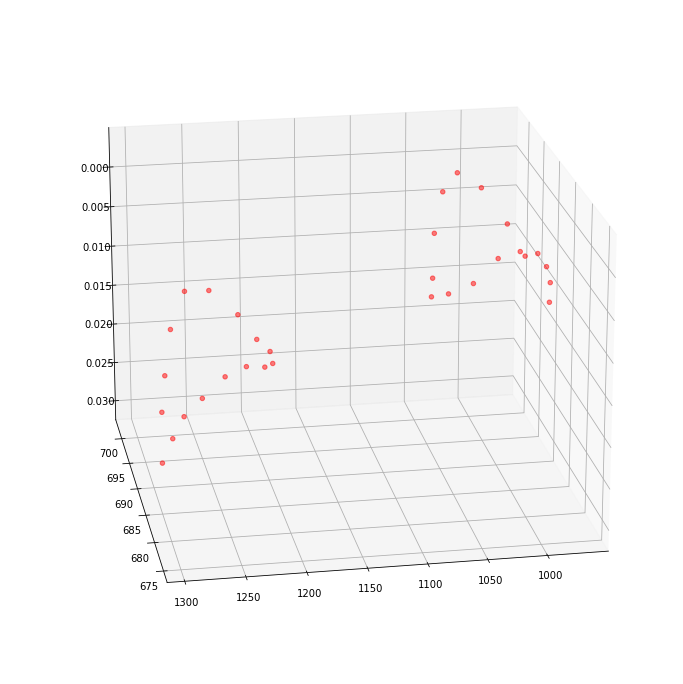

In [52]:
fig = plt.figure(figsize=(12,18))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(200,100)
x = eyes_df['x']
y = eyes_df['y']
z = eyes_df['z']
ax.scatter(x,y,z, c='r', alpha=0.5)